In [1]:
%matplotlib widget

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
plt.style.use("C:/Users/slab/.matplotlib/.config/prx.mplstyle")


from qick import *
from qick.helpers import gauss
from tqdm import tqdm_notebook as tqdm

import time
import os
import sys
sys.path.append('/home/xilinx/jupyter_notebooks/')
import scipy as sp
import json
from scipy.fft import fft, fftfreq
import Pyro4.util

from slab.instruments import *
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename, AttrDict

# # Figure params
# plt.rcParams['figure.figsize'] = [10,6]
# plt.rcParams.update({'font.size': 14})

import experiments as meas

Could not import QickInstrument (will only work if running on rfsoc). If running on rfsoc, try install/update qick package
Warning failed to import AWG81180A
Warning failed to import Tek5014
Warning failed to import Tek70001
Warning failed to import M8195A
imported experiments.clifford_averager_program
imported experiments.fitting
imported experiments.four_qubit.fourQ_state_tomo
imported experiments.qram_protocol_timestepped
imported experiments.single_qubit.acstarkshift_spectroscopy
imported experiments.single_qubit.amplitude_rabi
imported experiments.single_qubit.length_rabi
imported experiments.single_qubit.pulse_probe_spectroscopy
imported experiments.single_qubit.resonator_spectroscopy
imported experiments.single_qubit.rfsoc_tof_calibration
imported experiments.single_qubit.single_shot
imported experiments.single_qubit.t1
imported experiments.single_qubit.t2_ramsey
imported experiments.three_qubit.threeQ_state_tomo
imported experiments.two_qubit.amplitude_rabi_EgGf
imported experi

In [3]:
"""Reopen saved data"""
def prev_data(expt_path, filename=None):
    temp_data_file = expt_path
    if filename is not None: temp_data_file = os.path.join(expt_path, filename)
    print(temp_data_file)
    with SlabFile(temp_data_file) as a:
        attrs = dict()
        for key in list(a.attrs):
            attrs.update({key:json.loads(a.attrs[key])})
        keys = list(a)
        temp_data = dict()
        for key in keys:
            temp_data.update({key:np.array(a[key])})
        print(f'Extracted data and attrs {list(a.attrs)}')
    return temp_data, attrs

In [4]:
data_path = 'S:\\QRAM\\qram_4QR2\\'
# expt_path = os.path.join(data_path, 'data', 'data_241007')
expt_path = os.path.join(data_path, 'data', 'data_240617')
print('Data will be stored in', expt_path)

Data will be stored in S:\QRAM\qram_4QR2\data\data_240617


In [5]:
config_file = 'config_q3diamond_full688and638_reset.yml'
# config_file = 'config_q3diamond_full688_reset.yml'
# config_file = 'config_q3diamond.yml'
# config_file = 'config_zcu216.yml'
# config_file = 'config_zcu216_LLStdCandle.yml'
config_file = 'config_q3diamond_full688and638_reset.yml'
config_path = os.path.join('s:\\Connie\\experiments\\qram_tprocv1_expts\\configs\\', config_file)
print('Config will be', config_path)

Config will be s:\Connie\experiments\qram_tprocv1_expts\configs\config_q3diamond_full688and638_reset.yml


# Single shots

In [6]:
best_gain = [0.20, 0.30, 0.78, 0.25]
best_length = [15, 10, 5, 20]

## Import files

In [ ]:
filename = '_multi_readout_qubit'

# # Q0 
qubit = 0
idx = np.arange(2, 62)
file_nb =  ['0000'+str(i) for i in idx]
# # trim zeros to make all element 5 digits
file_nb = [i[-5:] for i in file_nb]
# file_nb = ['00063']


# # #Q1
# qubit = 1
# # idx = np.arange(27, 87)
# # file_nb =  ['000'+str(i) for i in idx]
# # file_nb = [i[-5:] for i in file_nb]
# file_nb = ['00088']


# Q3
# qubit = 3
# idx = np.arange(3, 63)
# idx = np.arange(3, 4)
# file_nb =  ['0000'+str(i) for i in idx]
# trim zeros to make all element 5 digits
# file_nb = [i[-5:] for i in file_nb]

# file_nb = ['00104']

# idx = np.arange(63, 83)
# file_nb =  ['000'+str(i) for i in idx]
# idx = np.arange(83, 103)
# file_nb =  ['000'+str(i) for i in idx]
# file_nb = [i[-5:] for i in file_nb]


# # Q2 
# qubit = 2
# idx = np.arange(0, 40)
# file_nb =  ['0000'+str(i) for i in idx]
# # trim zeros to make all element 5 digits
# file_nb = [i[-5:] for i in file_nb]
# file_nb = ['00040']



data = []


for nb in file_nb:
    temp_data = prev_data(expt_path, f'{nb}{filename}{qubit}.h5')
    data.append(temp_data)

pop_g = []
perr_g = []
gain_list = []
ro_length = []
pop_qnd_g = []

### Check QNDness

In [ ]:
for idx, d in enumerate(data):
    _data, _attrs = data[idx]
    
    
    shot = meas.MultiReadoutExperiment(config_file=config_path)
    
    config =  AttrDict(_attrs['config'])
    shot.cfg = config
    
    gain_list.append(config.device.readout.gain[qubit])
    ro_length.append(config.device.readout.readout_length[qubit])
    optimal = False
    print(np.round(gain_list[-1], 2))
    print(best_gain[qubit])
    if np.round(gain_list[-1], 2) == np.round(best_gain[qubit],2) and ro_length[-1] == best_length[qubit]:
        print('Optimal')
        optimal = True

        _d = shot.analyze(data=_data, check_readouts=[0,1], post_select=True, ps_adjust=[0, 0, 0, 1], verbose=False, fit=True, plot=True, check_qnd=True, opti_post_select=optimal)
    # shot.display(data=_d, fit=False, verbose=False)
    
    
    popts_g = _d['popts'][0]
    pcovs_g = _d['pcovs'][0]
    pop_qnd_g.append(_d['n_diff_qnd'])

    perr = np.sqrt(np.diag(pcovs_g))
    print(perr)
    
    pg = popts_g[0]/(popts_g[3] + popts_g[0])
    # using the formula for the error of a ratio
    
    pop_g_err = 1/(popts_g[3] + popts_g[0]) * np.sqrt((popts_g[3]/popts_g[0])**2*perr[0]**2 + perr[3]**2)
    # pop_g_err = pg*np.sqrt((perr[0]/popts_g[0])**2 + (perr[3]/popts_g[3])**2)
    perr_g.append(pop_g_err)
    
    
    pop_g.append(popts_g[0]/(popts_g[3] + popts_g[0]))

    

In [ ]:
# convert the pop_g to numpy array

pop_g = np.array(pop_g)
perr_g = np.array(perr_g)

gain = np.array(gain_list)
ro_length = np.array(ro_length)

gain = np.unique(gain)
ro_length = np.unique(ro_length)

# reshape both using the gain_list and 

pop_g = pop_g.reshape(ro_length.size, gain.size)
perr_g = perr_g.reshape(ro_length.size, gain.size)
pop_qnd_g = np.array(pop_qnd_g).reshape(ro_length.size, gain.size)

In [ ]:

fig, ax = plt.subplots(1, 2,  figsize=(8,4))

[ax[0].errorbar(gain, pop_g[i, :], yerr=perr_g[i, :], fmt='o', label='qubit'+str(qubit)+' ro_length='+str(ro_length[i])) for i in range(ro_length.size)]

[ax[1].plot(gain, pop_qnd_g[i, :]*100,'-o', label='qubit'+str(qubit)+' ro_length='+str(ro_length[i])) for i in range(ro_length.size)]


ax[0].set_xlabel('Readout Gain')
ax[1].set_xlabel('Readout Gain')
ax[0].set_ylabel('Pop in |g>, prep |g>')
ax[1].set_ylabel('QND Pop in |g>, prep |g>')
ax[0].legend()
fig.tight_layout()





### Play with the waiting time

S:\QRAM\qram_4QR2\data\data_240617\00138_multi_readout_qubit3.h5
Extracted data and attrs ['config']
S:\QRAM\qram_4QR2\data\data_240617\00139_multi_readout_qubit3.h5
Extracted data and attrs ['config']
S:\QRAM\qram_4QR2\data\data_240617\00140_multi_readout_qubit3.h5
Extracted data and attrs ['config']
S:\QRAM\qram_4QR2\data\data_240617\00141_multi_readout_qubit3.h5
Extracted data and attrs ['config']
S:\QRAM\qram_4QR2\data\data_240617\00142_multi_readout_qubit3.h5
Extracted data and attrs ['config']
S:\QRAM\qram_4QR2\data\data_240617\00143_multi_readout_qubit3.h5
Extracted data and attrs ['config']
S:\QRAM\qram_4QR2\data\data_240617\00144_multi_readout_qubit3.h5
Extracted data and attrs ['config']


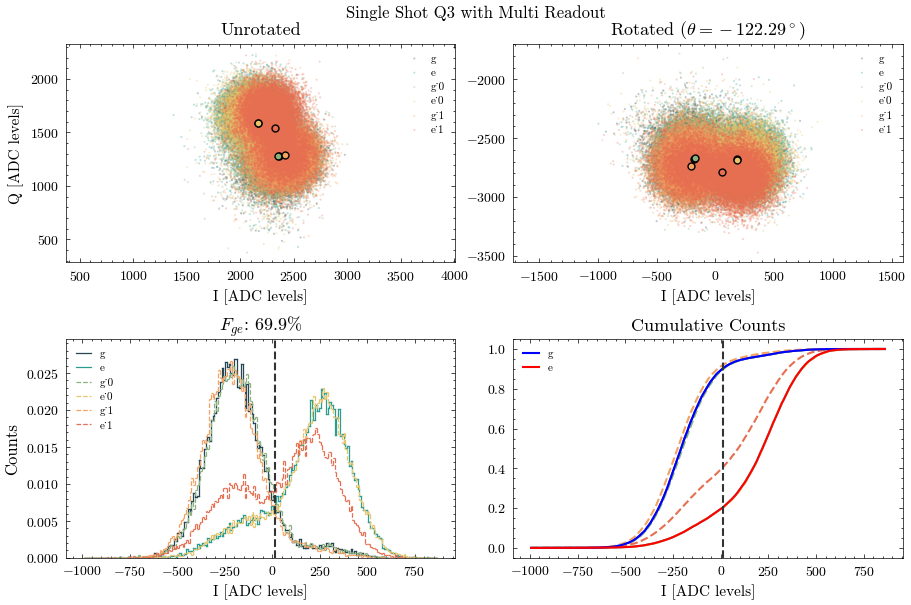

4
[[0.6987500000000004], [12.639051763683597], -122.29016974318353, 0.07669999999999999]
Post-selecting
opti post select
10
[-435.48254637 -391.38820148 -347.29385658 -303.19951168 -259.10516679
 -215.01082189 -170.91647699 -126.8221321   -82.7277872   -38.6334423
    5.46090259   45.60208034   84.97458669  124.34709305  163.7195994
  203.09210575  242.46461211  281.83711846  321.20962482  360.58213117]
optimal threshold 5.460902594422294
n_e 0.04539295392953929
n_g 0.9546070460704607
n_e_prev 0.0815122268340251
n_g_prev 0.9184877731659749


 s:\Seb\experiements\qram_tprocv1_expts\experiments\single_qubit\single_shot.py: 1248

4
[[0.69595], [40.896798843609304], -121.88581946230337, 0.04575]
Post-selecting
opti post select
11
[-388.73480787 -346.45984428 -304.18488069 -261.9099171  -219.63495351
 -177.35998992 -135.08502633  -92.81006274  -50.53509915   -8.26013556
   34.01482803   74.89137627  115.49601041  156.10064456  196.70527871
  237.30991285  277.914547    318.51918115  359.12381529  399.72844944]
optimal threshold 74.89137626842668
n_e 0.05942995755003032
n_g 0.9405700424499697
n_e_prev 0.09685484274213711
n_g_prev 0.9031451572578629
4
[[0.6958], [73.10724840830642], -121.79145820792426, 0.04625]
Post-selecting
opti post select
11
[-375.09046283 -330.98862854 -286.88679425 -242.78495997 -198.68312568
 -154.58129139 -110.47945711  -66.37762282  -22.27578854   21.82604575
   65.92788004  105.64351023  144.50626741  183.3690246   222.23178178
  261.09453896  299.95729614  338.82005332  377.6828105   416.54556768]
optimal threshold 105.64351023401213
n_e 0.06097761234878756
n_g 0.9390223876512125
n_e_pr

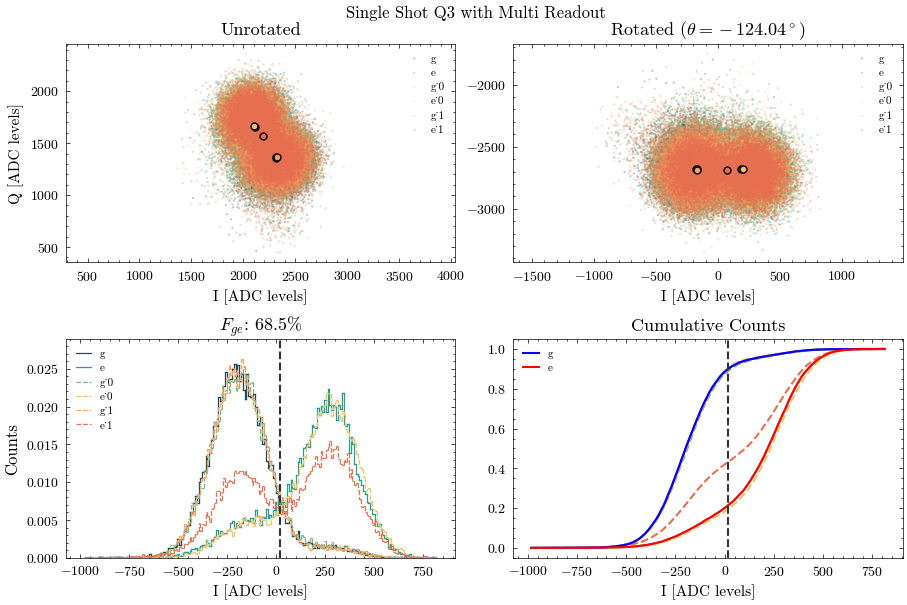

4
[[0.6854499999999999], [19.079817254294653], -124.0448065679332, 0.041949999999999994]
Post-selecting
opti post select
11
[-423.60388863 -380.04462238 -336.48535612 -292.92608987 -249.36682362
 -205.80755736 -162.24829111 -118.68902485  -75.1297586   -31.57049234
   11.98877391   50.2923214    87.57392358  124.85552575  162.13712793
  199.4187301   236.70033228  273.98193445  311.26353663  348.5451388 ]
optimal threshold 50.2923214008599
n_e 0.06872965966131613
n_g 0.9312703403386838
n_e_prev 0.1037
n_g_prev 0.8963
4
[[0.697], [87.4312945611689], -122.93715325670324, 0.03485]
Post-selecting
opti post select
11
[-338.87284059 -296.92529411 -254.97774763 -213.03020115 -171.08265467
 -129.13510819  -87.18756171  -45.24001523   -3.29246876   38.65507772
   80.6026242   121.88100665  163.02927387  204.17754109  245.3258083
  286.47407552  327.62234274  368.77060996  409.91887717  451.06714439]
optimal threshold 121.88100665029809
n_e 0.07485541173230514
n_g 0.9251445882676949
n_e_prev 0.1

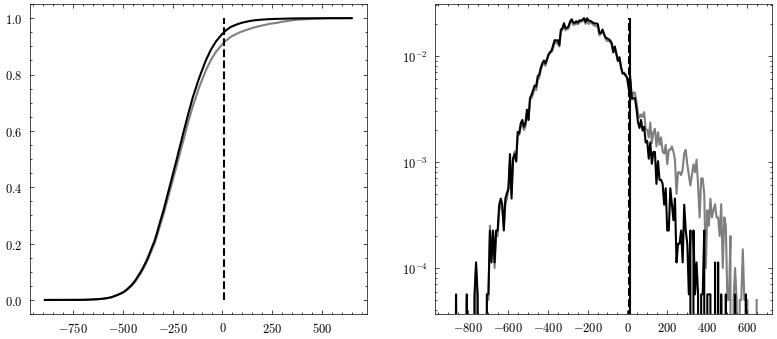

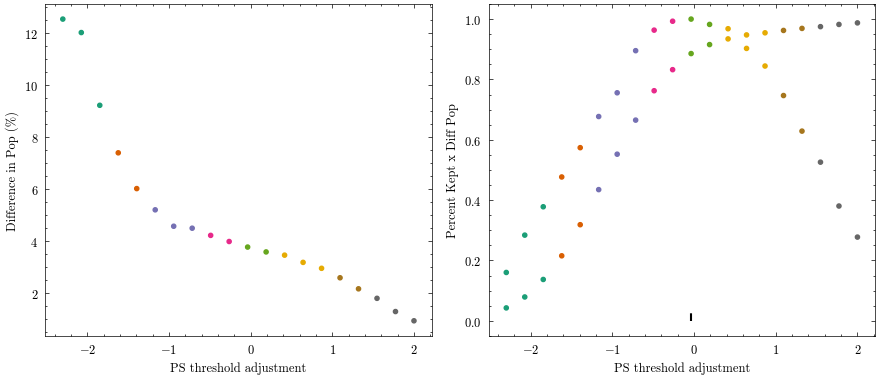

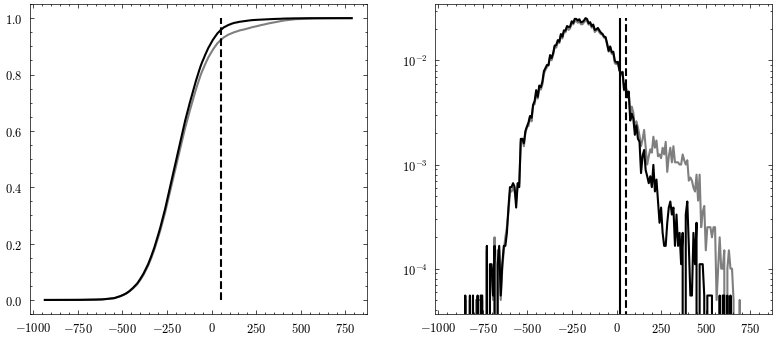

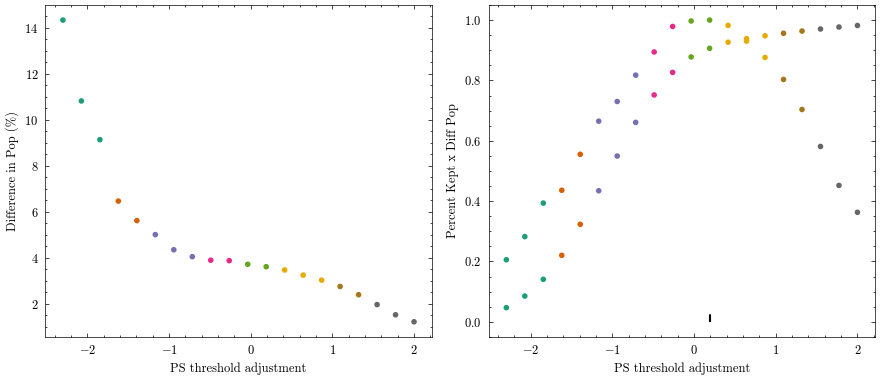

In [37]:

# q0 
# idx = np.arange(89, 98)
# idx = np.arange(64, 70)
# qubit=0
# file_nb =  ['000'+str(i) for i in idx]
# q1
# idx = np.arange(172, 177)
# qubit=1
# file_nb =  ['00'+str(i) for i in idx]
# # q2
# idx = np.arange(68, 78)
# qubit=2
# file_nb =  ['000'+str(i) for i in idx]
# q3
idx = np.arange(138, 145)
# idx = np.arange(105, 115)
qubit=3
file_nb =  ['00'+str(i) for i in idx]


filename = '_multi_readout_qubit'

wait_vec = []
pop_qnd_g = []
pop_diff = []

pop_vec = []
pop_vec_no_ps = []
data = []
n_ps = []
n_prev = []

for nb in file_nb:
    temp_data = prev_data(expt_path, f'{nb}{filename}{qubit}.h5')
    data.append(temp_data)
    

for idx, d in enumerate(data):
    
    _data, _attrs = data[idx]
    shot = meas.MultiReadoutExperiment(config_file=config_path)
    
    config =  AttrDict(_attrs['config'])
    shot.cfg = config
    
    plot = False
    if idx == 0 or idx == len(data)-2:
        plot = True
    
    _d = shot.analyze(data=_data, check_readouts=[0,1], post_select=True, ps_adjust=[0, 0, 0, 0], verbose=False, fit=False, plot=plot, check_qnd=True, opti_post_select=True)    
    wait_vec.append(config.expt.init_read_wait_us)
    pop_qnd_g.append(_d['n_diff_qnd'])
    pop_diff.append(_d['n_diff_opt'])

    pop_vec.append(_d['n_ps'][1])
    pop_vec_no_ps.append(_d['n_no_ps'][1])
    
    n_ps.append(_d['ncounts_ps'])
    n_prev.append(_d['ncounts_no_ps'])

    
         

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


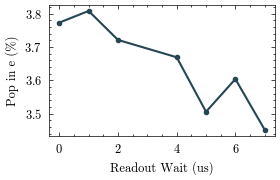

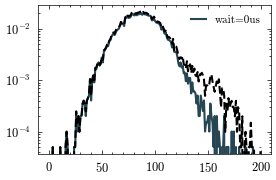

In [38]:
fig, (ax1) = plt.subplots(1, 1,  figsize=(3,2))

# ax1.plot(wait_vec, np.array(pop_qnd_g)*100,'-o', label='nonQNDness')
ax1.plot(wait_vec, np.array(pop_diff)*100,'-o')


# ax2.plot(wait_vec, np.array(pop_vec)*100,'-o', label='PS')
# ax2.plot(wait_vec, np.array(pop_vec_no_ps)*100,'-o', label='no PS')

ax1.set_xlabel('Readout Wait (us)')
ax1.set_ylabel('Pop in e (%)')
fig.tight_layout()
ax1.legend()
# ax2.legend()

fig2, ax = plt.subplots(1, 1,  figsize=(3,2))
for i in range(len(n_ps)):
    nplot = n_ps[i]
    # idx = np.argmax(nplot)
    if  wait_vec[i] == 10: idx = 10
    else: idx = 0
    x= np.arange(len(nplot))
    if wait_vec[i] == 0 or wait_vec[i] == 10:
        ax.plot(x - idx, n_ps[i], label=f'wait={wait_vec[i]}us')
        ax.plot(x - idx, n_prev[i], color='black', linestyle='--')
        
        # ax[1].plot(x - idx, np.cumsum(n_ps[i]), label=f'wait={wait_vec[i]}')
        # ax[1].plot(x - idx, np.cumsum(n_prev[i]), color='black', linestyle='--')
        
fig.tight_layout()
fig2.tight_layout()
ax.legend()
ax.set_yscale('log')
fig.savefig('S:\\QRAM\\qram_4QR2\\plots\\qubit0_pop_correction.pdf')
fig2.savefig('S:\\QRAM\\qram_4QR2\\plots\\counts.pdf')

### Play with the number of trigger

In [ ]:
# idx = np.arange(99, 105)
# qubit = 1

idx= np.arange(71, 77)
qubit = 0


file_nb =  ['000'+str(i) for i in idx]
file_nb = [i[-5:] for i in file_nb]
filename = '_multi_readout_qubit'

data = []

for nb in file_nb:
    temp_data = prev_data(expt_path, f'{nb}{filename}{qubit}.h5')
    data.append(temp_data)
    
n_trigger = []
pop_qnd_g = []
pop_diff = []

for idx, d in enumerate(data):
        
        _data, _attrs = data[idx]
        shot = meas.MultiReadoutExperiment(config_file=config_path)
        
        config =  AttrDict(_attrs['config'])
        shot.cfg = config
        
        n_trigger.append(config.expt.n_trig)
        
        _d = shot.analyze(data=_data, check_readouts=[0,1], post_select=True, ps_adjust=[0, 0, 0, 1], verbose=False, fit=True, plot=True, check_qnd=True, opti_post_select=True)
        
        pop_qnd_g.append(_d['n_diff_qnd'])
        pop_diff.append(_d['n_diff_opt'])

In [ ]:
fig, ax = plt.subplots(1, 1,  figsize=(4,4))

# ax.plot(n_trigger, np.array(pop_qnd_g)*100,'-o', label='nonQNDness')
ax.plot(n_trigger, np.array(pop_diff)*100,'-o', label='pop correction')



# $\pi$ - $\pi$

In [ ]:
filename = '00001_CDistortPiMinusPiExpt1.h5'
data = prev_data(expt_path, filename)

In [ ]:
_data, _attrs = data

In [ ]:
_data.keys()

In [ ]:
amp = np.asarray(_data['amps'])

cycle_sweep = np.asarray(_data['cycle_sweep'])
time_sweep = np.asarray(_data['time_sweep'])

In [ ]:
fig, ax = plt.subplots(1, 1,  figsize=(6,4))

nb_slice = 4
idx_slice = np.arange(0, amp.shape[1], nb_slice)

[ax.plot(cycle_sweep, amp[:, i], label='t = '+str(time_sweep[i])) for i in idx_slice]

fig.tight_layout()

ax.legend()

ax.set_xlabel('N cycle')
ax.set_ylabel('Pop')